Load Dataset
Data Pre-processing
Feature Scaling
Split Data
Train Data

In [1]:
!zip -r /kaggle/working/files.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



In [3]:
!ls -R /kaggle/input

/kaggle/input:
spark-2025-heart-failure-prediction

/kaggle/input/spark-2025-heart-failure-prediction:
sample.csv  test.csv  train.csv


In [4]:
#Load Train Dataset
file_path = '/kaggle/input/spark-2025-heart-failure-prediction/train.csv'
df = pd.read_csv(file_path)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,83327,18995,2,162,83.0,120,80,1,1,0,0,0,1
1,86196,17319,1,158,64.0,120,80,1,1,0,0,1,0
2,59158,19017,1,165,95.0,160,100,2,1,0,0,1,1
3,16399,20388,1,164,83.0,150,100,1,1,0,0,1,1
4,29470,18236,1,156,52.0,100,67,1,1,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56000 entries, 0 to 55999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           56000 non-null  int64  
 1   age          56000 non-null  int64  
 2   gender       56000 non-null  int64  
 3   height       56000 non-null  int64  
 4   weight       56000 non-null  float64
 5   ap_hi        56000 non-null  int64  
 6   ap_lo        56000 non-null  int64  
 7   cholesterol  56000 non-null  int64  
 8   gluc         56000 non-null  int64  
 9   smoke        56000 non-null  int64  
 10  alco         56000 non-null  int64  
 11  active       56000 non-null  int64  
 12  cardio       56000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 5.6 MB


**DATA PREPROCESSING**

In [6]:
#Data preprocessing

df.dropna(inplace=True) #drop rows with null values
df.drop(columns=["id"], inplace=True) #drop ID column
df['age'] = df['age']/365

In [7]:
#Remove Illogical Negative Values

num_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
for i in num_cols:
    print(i, (df[i] < 0).sum())
    


age 0
height 0
weight 0
ap_hi 5
ap_lo 1


BP cannot be Negative

In [8]:
min(df['ap_lo']), min(df['ap_hi']) #check the lowest values of 'ap_lo' and "ap_hi"


(-70, -150)

In [9]:
df[['ap_hi', 'ap_lo']] = df[['ap_hi', 'ap_lo']].abs() #Absolute value to remove the negative and give absolute values
min(df['ap_lo']), min(df['ap_hi']) #check the lowest values of 'ap_lo' and "ap_hi"

(0, 1)

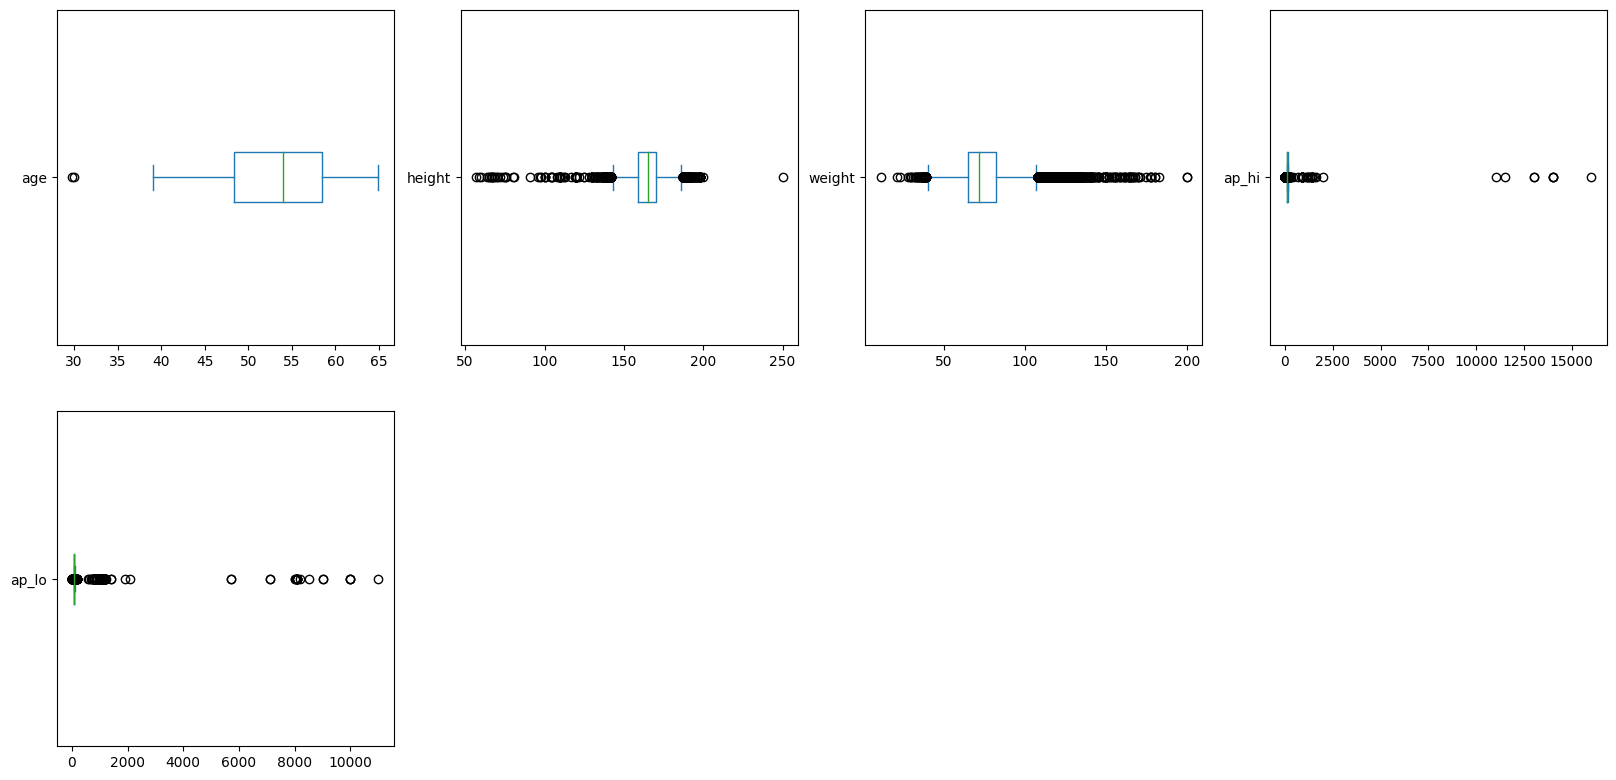

In [10]:
#check for outliers

df[num_cols].plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, vert = False)
plt.gcf().set_size_inches(20,20)
plt.show()

In [11]:
#Remove outliers
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1  #getting interquartile range of selected columns

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned = df[~((df[num_cols] < lower_bound) | (df[num_cols] > upper_bound)).any(axis=1)]

print(f"Original dataset shape: {df.shape}")
print(f"Dataset after outlier removal: {df_cleaned.shape}")

df = df_cleaned.copy()

Original dataset shape: (56000, 12)
Dataset after outlier removal: (50036, 12)


In [12]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,52.041096,2,162,83.0,120,80,1,1,0,0,0,1
1,47.449315,1,158,64.0,120,80,1,1,0,0,1,0
2,52.101370,1,165,95.0,160,100,2,1,0,0,1,1
3,55.857534,1,164,83.0,150,100,1,1,0,0,1,1
4,49.961644,1,156,52.0,100,67,1,1,0,0,0,0


In [13]:
# One-Hot Encoding; Gender should be One hot encoded to avoid giving bias to a gender
df['male'] = (df['gender'] == 2).astype(int)
df['female'] = (df['gender'] == 1).astype(int)
df.drop(columns=["gender"], inplace=True) #Why? because we have already created new columns for each gender so no need for the gender column
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50036 entries, 0 to 55999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          50036 non-null  float64
 1   height       50036 non-null  int64  
 2   weight       50036 non-null  float64
 3   ap_hi        50036 non-null  int64  
 4   ap_lo        50036 non-null  int64  
 5   cholesterol  50036 non-null  int64  
 6   gluc         50036 non-null  int64  
 7   smoke        50036 non-null  int64  
 8   alco         50036 non-null  int64  
 9   active       50036 non-null  int64  
 10  cardio       50036 non-null  int64  
 11  male         50036 non-null  int64  
 12  female       50036 non-null  int64  
dtypes: float64(2), int64(11)
memory usage: 5.3 MB


In [14]:
#Define Feature and Target

X = df.drop(columns=["cardio"])  # ust Features
y = df["cardio"] #Just Target

X.head()

,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,male,female
0,52.041096,162,83.0,120,80,1,1,0,0,0,1,0
1,47.449315,158,64.0,120,80,1,1,0,0,1,0,1
2,52.101370,165,95.0,160,100,2,1,0,0,1,0,1
3,55.857534,164,83.0,150,100,1,1,0,0,1,0,1
4,49.961644,156,52.0,100,67,1,1,0,0,0,0,1


In [15]:
#Check Dataset Balance
print(y.value_counts(normalize=True))

cardio
0    0.505896
1    0.494104
Name: proportion, dtype: float64


**It is a balanced dataset**

In [16]:
#Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [17]:
#Splitting data

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state = 42)

feature_names = np.array(X.columns)  



**MODELLING**

In [18]:
#Feature Selection with RFECV
#RFECV selects features based on performance. 
#We use RFECV (Recursive Feature Elimination with Cross-Validation) to automatically determine the best number of features.

model = LogisticRegression()  # RFECV uses a model for automatic feature selection so we don't have to manually guess for 'k'
rfecv = RFECV(model, step=1, cv=5, scoring="accuracy")  # Automatically selects best features
X_train_selected = rfecv.fit_transform(X_train, y_train)
X_test_selected = rfecv.transform(X_test)

# Get selected feature names
selected_features = feature_names[rfecv.support_]
print("Optimal Features Selected:", selected_features.tolist())

Optimal Features Selected: ['age', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'smoke', 'active']


We used RFECV to select the most important features that contribute to the model's predictive performance.
Now let's train the model with the selected features.

**TASK 1**

Train a Logistic Regression model and validate it using a classification report.


In [19]:
#Train Logistic Regression

lg = LogisticRegression()
lg.fit(X_train_selected,y_train)
y_pred_lg = lg.predict(X_test_selected)

#Validate using Classification report
log_reg_report = classification_report(y_test, y_pred_lg, output_dict=True)
print(f"Logistic Regression Report: \n{classification_report(y_test, y_pred_lg)}")


Logistic Regression Report: 
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      5015
           1       0.75      0.66      0.70      4993

    accuracy                           0.72     10008
   macro avg       0.72      0.72      0.72     10008
weighted avg       0.72      0.72      0.72     10008



**TASK 2**

Train a Decision Tree model and validate it using a classification report.

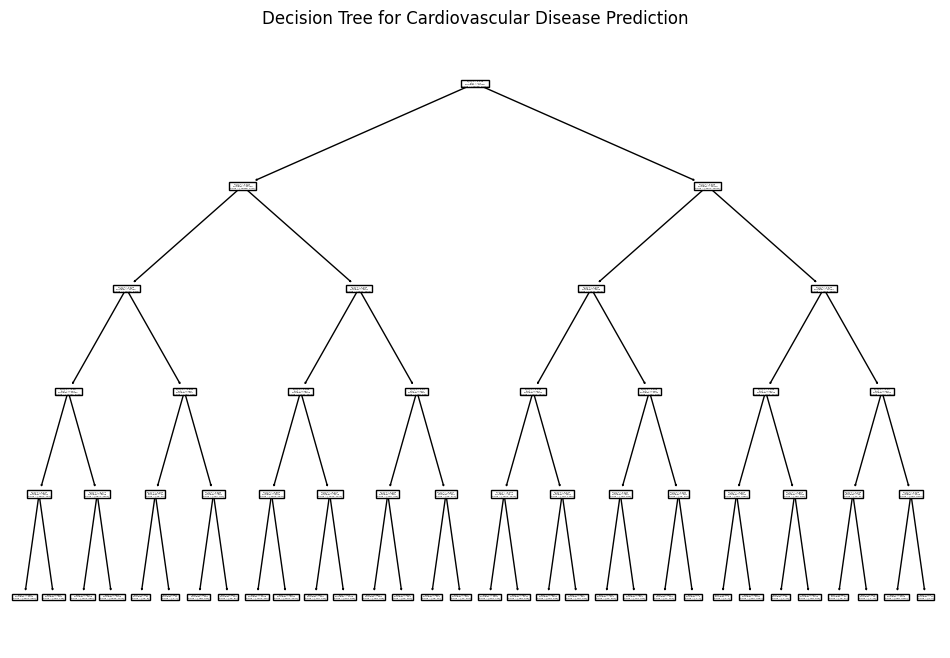

Decision Tree Report: 
               precision    recall  f1-score   support

           0       0.71      0.76      0.74      5015
           1       0.74      0.69      0.72      4993

    accuracy                           0.73     10008
   macro avg       0.73      0.73      0.73     10008
weighted avg       0.73      0.73      0.73     10008



In [20]:
#Train Decision Tree
clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
clf.fit(X_train_selected, y_train)
y_pred_clf = clf.predict(X_test_selected)
# Plot the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(clf)
plt.title("Decision Tree for Cardiovascular Disease Prediction")
plt.show()
#Validate using Classification Report
clf_report = classification_report(y_test, y_pred_clf, output_dict=True)
print(f"Decision Tree Report: \n {classification_report(y_test, y_pred_clf)}")


**TASK 3**

Train a Random Forest model and validate it using a classification report.

In [21]:
# Train Random Forest
rand_forest = RandomForestClassifier(n_estimators=100, random_state=42)
rand_forest.fit(X_train_selected, y_train)
y_pred_forest = rand_forest.predict(X_test_selected)


#Validate using Classification Report
rand_forest_report = classification_report(y_test, y_pred_forest, output_dict=True)
print(f"Random Forest Report:\n {classification_report(y_test, y_pred_forest)}")

Random Forest Report:
               precision    recall  f1-score   support

           0       0.69      0.68      0.68      5015
           1       0.68      0.69      0.69      4993

    accuracy                           0.69     10008
   macro avg       0.69      0.69      0.69     10008
weighted avg       0.69      0.69      0.69     10008



**TASK 4**

Compare the models using a confusion matrix and classification report to determine the best-performing model.

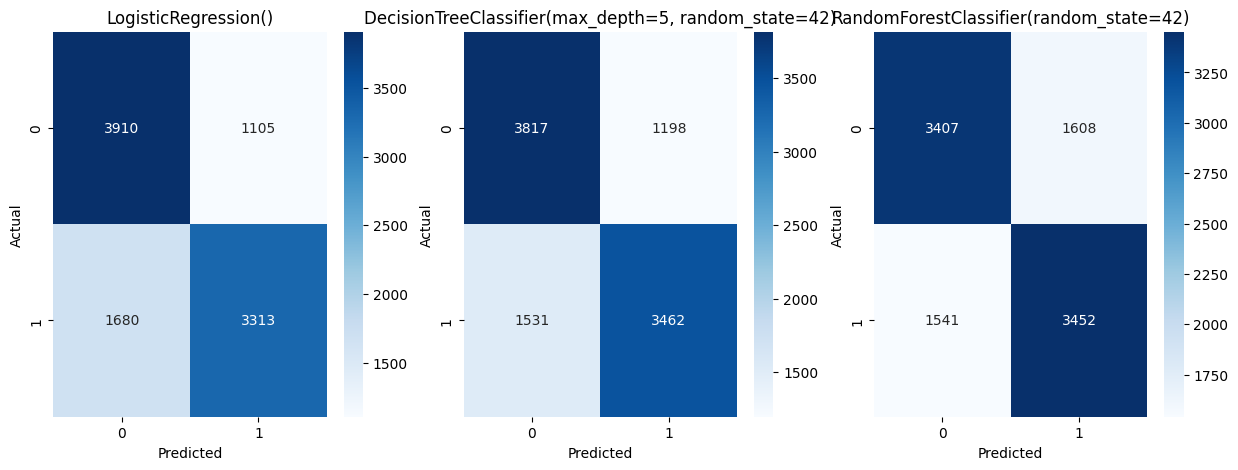

In [22]:
# Compare models with Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, model, preds, title in zip(axes, [y_pred_lg, y_pred_clf, y_pred_forest],
                                   ["Logistic Regression", "Decision Tree", "Random Forest"],
                                   [lg, clf, rand_forest]):
    sns.heatmap(confusion_matrix(y_test, model), annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.show()


In [23]:
#compare classification reports
# Convert reports to DataFrames for better visualization
log_reg_df = pd.DataFrame(log_reg_report).transpose()
dec_tree_df = pd.DataFrame(clf_report).transpose()
rand_forest_df = pd.DataFrame(rand_forest_report).transpose()

# Print reports side-by-side
print("\nLogistic Regression Classification Report:\n", log_reg_df)
print("\nDecision Tree Classification Report:\n", dec_tree_df)
print("\nRandom Forest Classification Report:\n", rand_forest_df)


Logistic Regression Classification Report:
               precision    recall  f1-score       support
0              0.699463  0.779661  0.737388   5015.000000
1              0.749887  0.663529  0.704070   4993.000000
accuracy       0.721723  0.721723  0.721723      0.721723
macro avg      0.724675  0.721595  0.720729  10008.000000
weighted avg   0.724620  0.721723  0.720765  10008.000000

Decision Tree Classification Report:
               precision    recall  f1-score       support
0              0.713725  0.761117  0.736659   5015.000000
1              0.742918  0.693371  0.717290   4993.000000
accuracy       0.727318  0.727318  0.727318      0.727318
macro avg      0.728322  0.727244  0.726975  10008.000000
weighted avg   0.728290  0.727318  0.726996  10008.000000

Random Forest Classification Report:
               precision    recall  f1-score       support
0              0.688561  0.679362  0.683931   5015.000000
1              0.682213  0.691368  0.686760   4993.000000
accurac

**Best performing Model based on Accuracy: Decision Tree**

**TASK 5**

Perform hyperparameter tuning for each model to improve performance. Use cross_val_score() on X_scaled and y to validate results.

In [24]:
# Hyperparameter tuning using GridSearchCV

def hypertune_model(model, parameter): 
        grid_search = GridSearchCV(model, parameter, cv=5, scoring='f1')  
        grid_search.fit(X_train_selected, y_train) 
        print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}") 
        return grid_search.best_estimator_  # Return the model with the best hyperparameters

In [25]:
best_log_reg = hypertune_model(LogisticRegression(), {"C": [0.01, 0.1, 1, 10]})
best_dec_tree = hypertune_model(DecisionTreeClassifier(),  {"max_depth": [3, 5, 10, None]})
best_rand_forest = hypertune_model(RandomForestClassifier(), {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 10, None]})

Best parameters for LogisticRegression: {'C': 1}
Best parameters for DecisionTreeClassifier: {'max_depth': 5}
Best parameters for RandomForestClassifier: {'max_depth': 10, 'n_estimators': 50}


In [26]:
#cross validation for logistic regression
scoring_metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]
model = best_log_reg

for metric in scoring_metrics:
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring=metric)
    print(f"{metric.upper()} Score: {scores.mean():.4f}")

ACCURACY Score: 0.7232
PRECISION Score: 0.7506
RECALL Score: 0.6586
F1 Score: 0.7016
ROC_AUC Score: 0.7877


In [27]:
#cross validation for Decision tree classifier
scoring_metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]
model = best_dec_tree

for metric in scoring_metrics:
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring=metric)
    print(f"{metric.upper()} Score: {scores.mean():.4f}")

ACCURACY Score: 0.7266
PRECISION Score: 0.7632
RECALL Score: 0.6483
F1 Score: 0.7006
ROC_AUC Score: 0.7869


In [28]:
#cross validation for Random Forest Classifier
scoring_metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]
model = best_rand_forest

for metric in scoring_metrics:
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring=metric)
    print(f"{metric.upper()} Score: {scores.mean():.4f}")

ACCURACY Score: 0.7316
PRECISION Score: 0.7558
RECALL Score: 0.6747
F1 Score: 0.7124
ROC_AUC Score: 0.7955


BEST PERFORMING MODEL BASED ON F1 EVALUATION METRICS IS **RANDOM FOREST CLASSIFIER**.


Why choose F1, that is what was said would be used to grade

In [29]:
best_model = best_rand_forest

In [30]:
#preprocess test data, we are going to pass the test data through the same processing as the train data

file_path = '/kaggle/input/spark-2025-heart-failure-prediction/test.csv'
test_data = pd.read_csv(file_path)  
test_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,26681,19386,1,155,59.5,120,85,1,1,0,0,1
1,58585,21081,1,160,59.0,130,90,1,1,0,0,1
2,54339,15129,2,175,88.0,120,80,2,1,0,0,1
3,17273,18785,2,177,62.0,120,90,1,1,0,0,1
4,25420,18171,1,167,81.0,120,80,1,1,0,0,1


In [31]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           14000 non-null  int64  
 1   age          14000 non-null  int64  
 2   gender       14000 non-null  int64  
 3   height       14000 non-null  int64  
 4   weight       14000 non-null  float64
 5   ap_hi        14000 non-null  int64  
 6   ap_lo        14000 non-null  int64  
 7   cholesterol  14000 non-null  int64  
 8   gluc         14000 non-null  int64  
 9   smoke        14000 non-null  int64  
 10  alco         14000 non-null  int64  
 11  active       14000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 1.3 MB


In [32]:
#Data preprocessing

test_data['age'] = test_data['age']/365
test_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,26681,53.112329,1,155,59.5,120,85,1,1,0,0,1
1,58585,57.756164,1,160,59.0,130,90,1,1,0,0,1
2,54339,41.449315,2,175,88.0,120,80,2,1,0,0,1
3,17273,51.465753,2,177,62.0,120,90,1,1,0,0,1
4,25420,49.783562,1,167,81.0,120,80,1,1,0,0,1


In [33]:
#Remove Illogical Negative Values

num_col = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
for i in num_col:
    print(i, (test_data[i] < 0).sum())
    

age 0
height 0
weight 0
ap_hi 2
ap_lo 0


In [34]:
min(test_data['ap_hi']) #check the lowest values of 'ap_lo' and "ap_hi"

-120

BP cannot be negative

In [35]:
test_data['ap_hi'] = test_data['ap_hi'].abs() #Absolute value to remove the negative and give absolute values
min(test_data['ap_hi']) #check the lowest values of 'ap_lo' and "ap_hi"

11

In [36]:
#Remove outliers
#Q1 = test_data[num_col].quantile(0.25)
#Q3 = test_data[num_col].quantile(0.75)
#IQR = Q3 - Q1  #getting interquartile range of selected columns

#lower_bound = Q1 - 1.5 * IQR
#upper_bound = Q3 + 1.5 * IQR

#test_data_cleaned = test_data[~((test_data[num_col] < lower_bound) | (test_data[num_col] > upper_bound)).any(axis=1)]

#print(f"Original dataset shape: {test_data.shape}")
#print(f"Dataset after outlier removal: {test_data_cleaned.shape}")

#test_data = test_data_cleaned.copy()

**Commented out "Remove outliers" because output expected as per submission guideline should remain 14000 rows**

In [37]:
id_test = test_data["id"]
test_data.drop(columns=["id"], inplace=True) #drop ID column

In [38]:
# One-Hot Encoding; Gender should be One hot encoded to avoid giving bias to a gender
test_data['male'] = (test_data['gender'] == 2).astype(int)
test_data['female'] = (test_data['gender'] == 1).astype(int)
test_data.drop(columns=["gender"], inplace=True) #Why? because we have already created new columns for each gender so no need for the gender column
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          14000 non-null  float64
 1   height       14000 non-null  int64  
 2   weight       14000 non-null  float64
 3   ap_hi        14000 non-null  int64  
 4   ap_lo        14000 non-null  int64  
 5   cholesterol  14000 non-null  int64  
 6   gluc         14000 non-null  int64  
 7   smoke        14000 non-null  int64  
 8   alco         14000 non-null  int64  
 9   active       14000 non-null  int64  
 10  male         14000 non-null  int64  
 11  female       14000 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 1.3 MB


In [39]:
#apply feature scaling
X_test_scaled = scaler.transform(test_data)

#apply feature selection
X_test_selected = rfecv.transform(X_test_scaled)

In [40]:
final_predictions = best_model.predict(X_test_selected)

In [41]:
print(f"Original dataset shape: {test_data.shape}")

Original dataset shape: (14000, 12)


In [42]:
# Create submission file
submission = pd.DataFrame({"id": id_test, "target": final_predictions}) 
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv
